# Solar Panel Adoption in Switzerland: Data Simulation and AI Model Creation

This notebook demonstrates the process of simulating a dataset for solar panel adoption in Switzerland and creating an AI model to predict installation based on various factors.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import check_random_state

# Set plot style
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Set random seed for reproducibility
np.random.seed(42)
check_random_state(42)


RandomState(MT19937) at 0x1756E5040

## Data Simulation

First, let's simulate a dataset for solar panel adoption in Switzerland.

For the independend variables we decided to choose these five metrics devided into economic and policy factors:

1. Economic factors
   - Price of energy - average price of energy used from the grid over the year in a given canton (CHF/kWh)
   - Feed in tariff - average price paid by the grid operator to solar panel owner for the energy produced and shared over the year in a given canton (CHF/kWh)
   - Solar panel cost - average price of solar panels over the year in a given canton (CHF/kW)
2. Policy factors
   - Tax deduction rate - cantonal tax deduction in a given year as a fraction of money invested in solar panels which can be deduced from yearly income
   - Subsidy amount - subsidy paid out by cantons in a given year for solar panel investment (CHF)

Apart from them, in order to capture the trends in the real data, we decieded to increase the energy prices over time and lower the cost of solar panels.

The choice of values for economic metrics comes from the real data. They were analyzed in previous steps and research. 

For the policy factors, we decided to ignore the change in policy and introduce more variability. In reality, the subsidy policy changed in 2018. Before that, KEV subsidy was meant to increase the feed in tariff and make the production of energy profitable. After 2018, KLEIV was introduced as a one time subsidy, proportional do the amount of power installed. Tax deduction rate is set at federal level and equals 100% of investment costs which makes it irrelevant for our analisis without introducing variability on cantonal level.

The choice of the factors is backed by the findings from these two papers:
- https://doi.org/10.1016/j.eneco.2016.07.008
- https://doi.org/10.1007/s43621-022-00108-4


   Year   Canton  Energy_Price  Feed_in_Tariff  Solar_Panel_Cost  \
0  2010   Zurich      0.159207        0.127492       4024.008073   
1  2010     Bern      0.248214        0.098702       3143.557581   
2  2010  Lucerne      0.193196        0.126435       3544.696695   
3  2010      Uri      0.230760        0.088072       3356.643493   
4  2010   Schwyz      0.148242        0.119384       4208.458792   

   Tax_Deduction_Rate  Subsidy_Amount  Likelihood  Installed_Power  
0            0.164847      680.705122    0.444099      7084.530293  
1            0.131841      381.235203    0.803899     21043.251595  
2            0.183645      909.850132    1.121971     42191.520133  
3            0.198060      467.457953    1.256119    111633.240413  
4            0.114522      799.424337    0.377223     20379.521809  

Dataset shape: (364, 9)

Summary Statistics for Installed Power:
count       364.000000
mean      92855.899707
std       60002.973650
min           0.000000
25%       42241.577

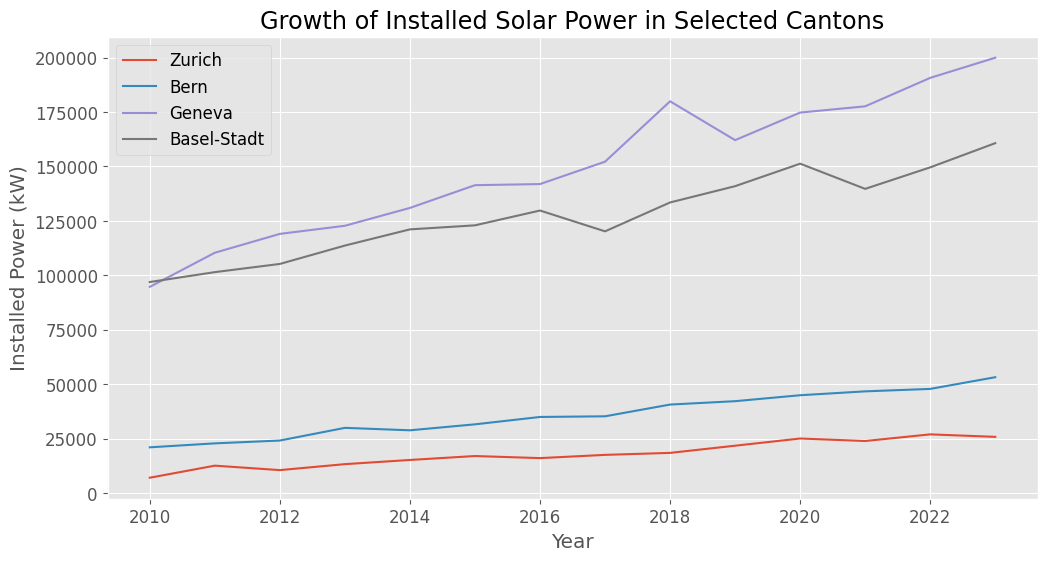

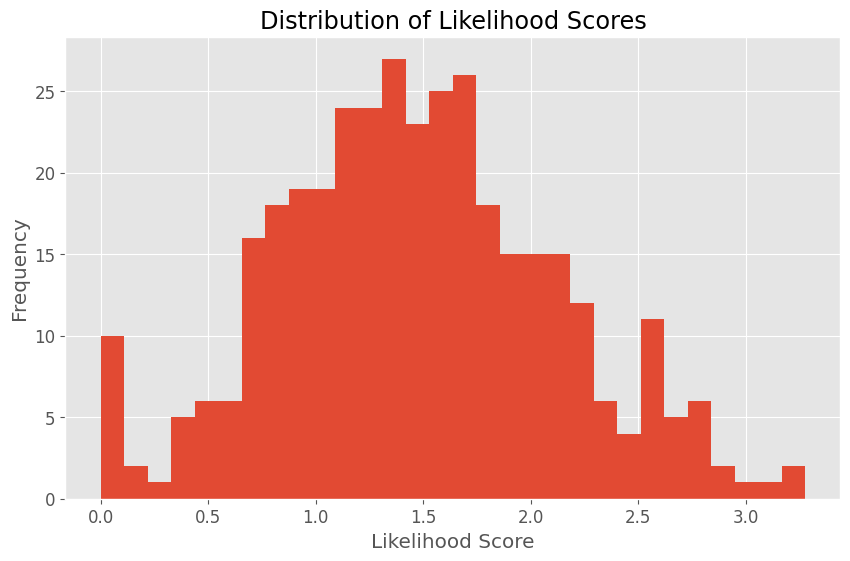

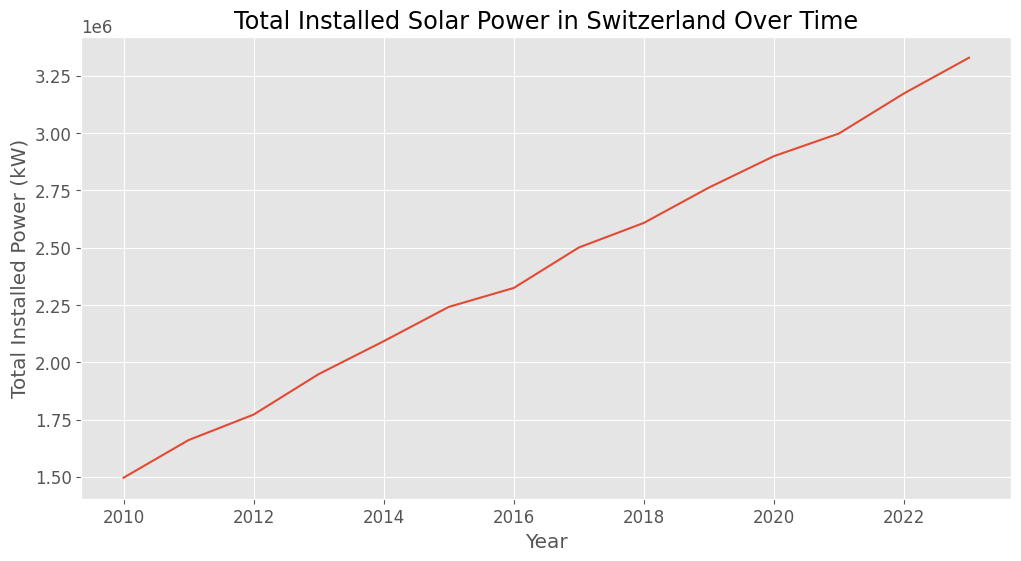

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Create a list of cantons
cantons = ['Zurich', 'Bern', 'Lucerne', 'Uri', 'Schwyz', 'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 
           'Solothurn', 'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen', 'Appenzell Ausserrhoden', 
           'Appenzell Innerrhoden', 'St. Gallen', 'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 
           'Valais', 'Neuchâtel', 'Geneva', 'Jura']

# Create a date range
years = range(2010, 2024)

# Generate base values for each canton
canton_base_values = {}
for canton in cantons:
    canton_base_values[canton] = {
        'energy_price': np.random.uniform(0.15, 0.25),
        'feed_in_tariff': np.random.uniform(0.08, 0.15),
        'solar_panel_cost': np.random.uniform(3000, 5000),
        'tax_deduction_rate': np.random.uniform(0.1, 0.3),
        'subsidy_amount': np.random.uniform(300, 1000),
        'base_power': np.random.uniform(10, 100),  # Lower initial base power
    }

# Create empty list to store the data
data = []

for year in years:
    for canton in cantons:
        base = canton_base_values[canton]
        
        # Small random variations each year
        energy_price = base['energy_price'] * (1.05 ** (year - 2010))  # 5% increase per year
        feed_in_tariff = base['feed_in_tariff'] * np.random.uniform(0.95, 1.05)
        solar_panel_cost = base['solar_panel_cost'] * (0.95 ** (year - 2010))  # 5% decrease per year
        tax_deduction_rate = base['tax_deduction_rate'] * np.random.uniform(0.95, 1.05)
        subsidy_amount = base['subsidy_amount'] * np.random.uniform(0.95, 1.05)
        
        # Add the data point to our list
        data.append([year, canton, energy_price, feed_in_tariff, solar_panel_cost, tax_deduction_rate, subsidy_amount])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Year', 'Canton', 'Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount'])

# Apply MinMaxScaler to the features
scaler = MinMaxScaler()
features_to_scale = ['Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount']
scaled = pd.DataFrame()
scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])


# Calculate likelihood score using scaled features
df['Likelihood'] = ((scaled['Energy_Price'] - scaled['Feed_in_Tariff']) + scaled['Subsidy_Amount'] + scaled['Tax_Deduction_Rate'] - scaled['Solar_Panel_Cost']) + 1

# Clip lower that 0
df['Likelihood'] = df['Likelihood'].clip(lower=0)

# Calculate installed power
for index, row in df.iterrows():
    canton = row['Canton']
    base = canton_base_values[canton]

    installed_power = base['base_power'] * row['Likelihood']
    installed_power *= np.random.uniform(0.95, 1.05)  # Add some randomness
    installed_power *= 1000 # Scale to real levels
    
    df.at[index, 'Installed_Power'] = installed_power

# Display the first few rows and dataset shape
print(df.head())
print(f"\nDataset shape: {df.shape}")

# Display summary statistics
print("\nSummary Statistics for Installed Power:")
print(df['Installed_Power'].describe())

# Display data for a single canton across all years
print("\nData for Zurich across all years:")
print(df[df['Canton'] == 'Zurich'].sort_values('Year'))

# Visualize the exponential growth for a few cantons
plt.figure(figsize=(12, 6))
for canton in ['Zurich', 'Bern', 'Geneva', 'Basel-Stadt']:
    canton_data = df[df['Canton'] == canton]
    plt.plot(canton_data['Year'], canton_data['Installed_Power'], label=canton)

plt.title('Growth of Installed Solar Power in Selected Cantons')
plt.xlabel('Year')
plt.ylabel('Installed Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution of likelihood scores
plt.figure(figsize=(10, 6))
plt.hist(df['Likelihood'], bins=30)
plt.title('Distribution of Likelihood Scores')
plt.xlabel('Likelihood Score')
plt.ylabel('Frequency')
plt.show()

# Visualize the total installed power over time
total_power = df.groupby('Year')['Installed_Power'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(total_power['Year'], total_power['Installed_Power'])
plt.title('Total Installed Solar Power in Switzerland Over Time')
plt.xlabel('Year')
plt.ylabel('Total Installed Power (kW)')
plt.grid(True)
plt.show()

# Export the processed dataset
df.to_csv('../data/simulated/simulated_dataset.csv', index=False)

## Exploratory Data Analysis

Now let's visualize our simulated data to understand the patterns and relationships.

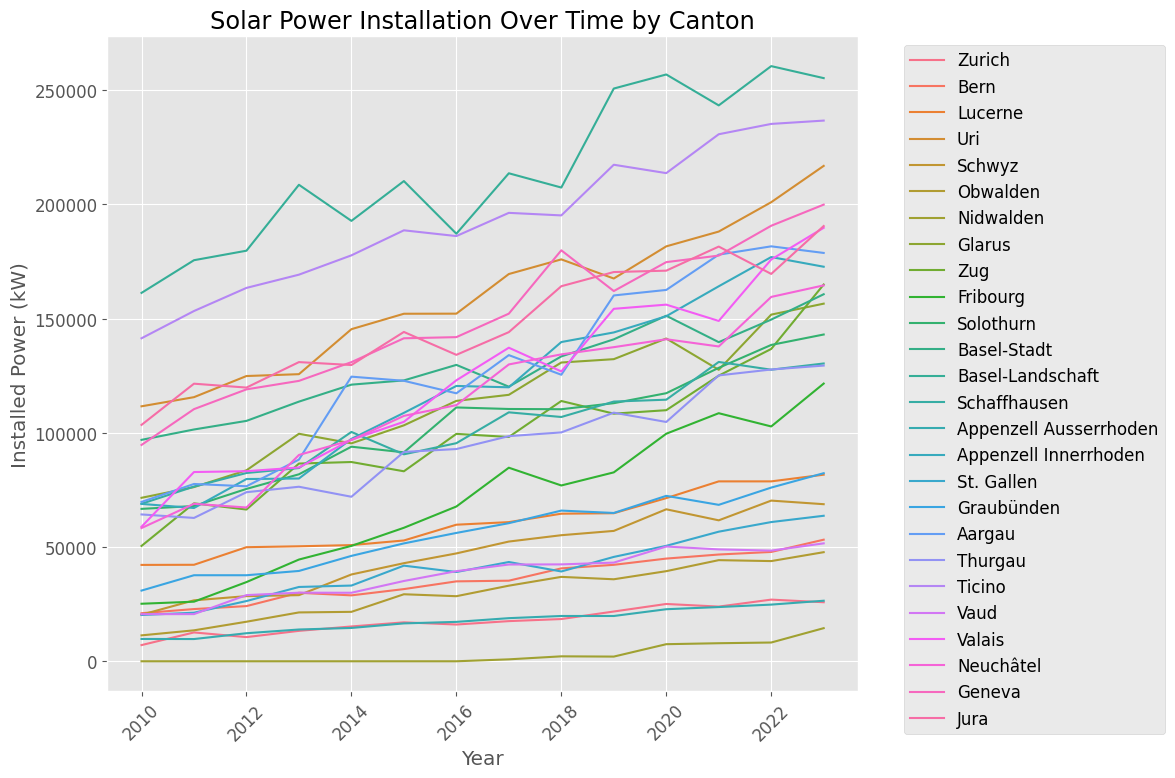

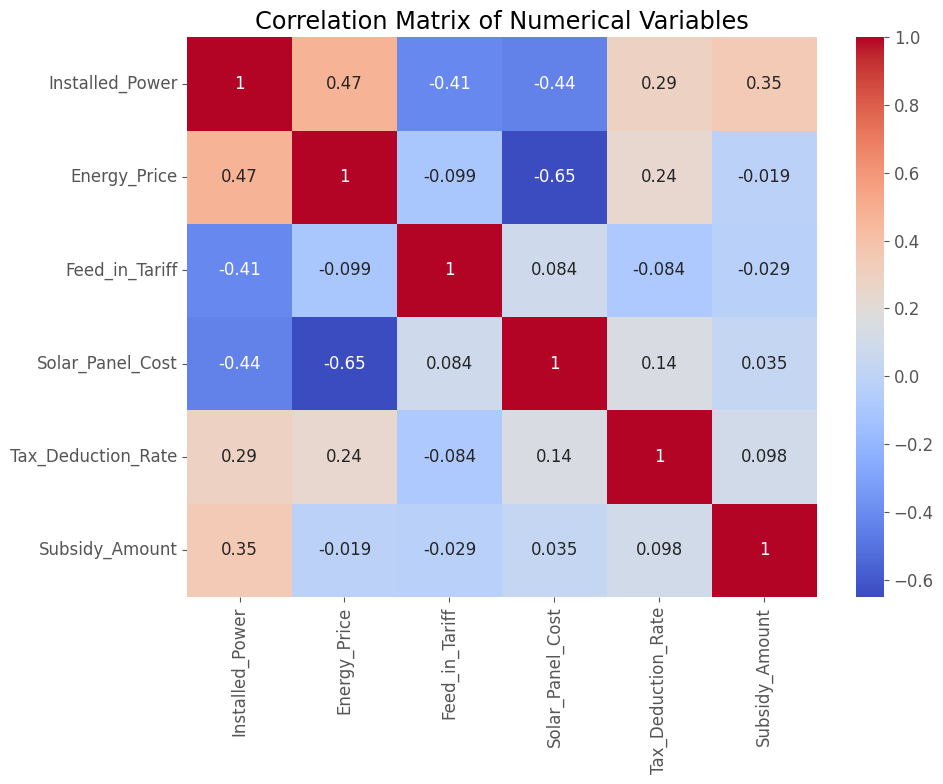

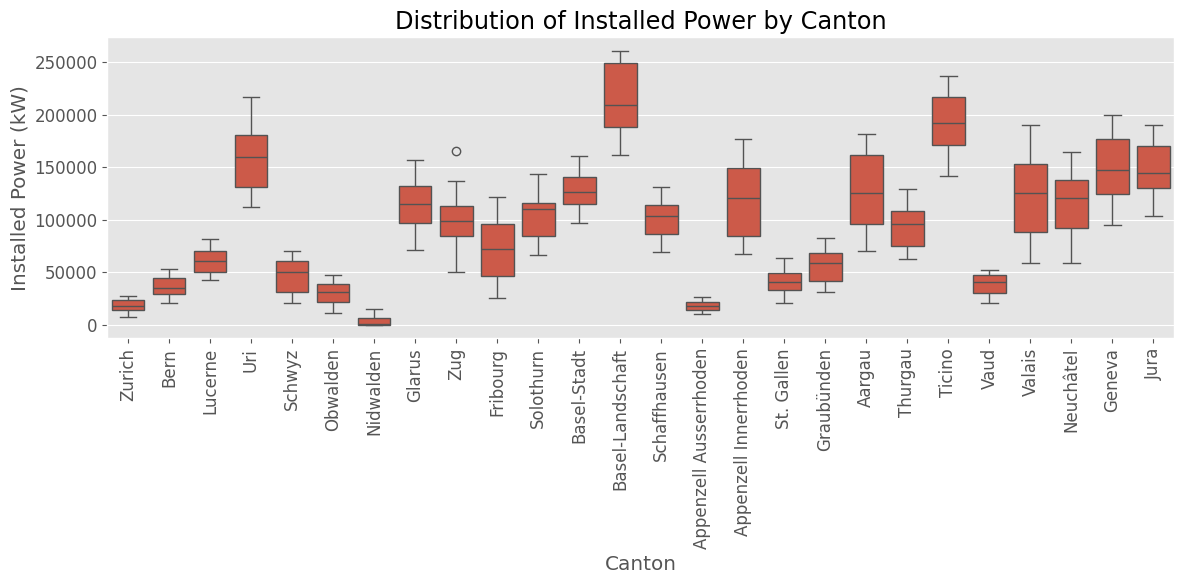

In [178]:
# Solar Power Installation Over Time by Canton
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Year', y='Installed_Power', hue='Canton')
plt.title('Solar Power Installation Over Time by Canton')
plt.ylabel('Installed Power (kW)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Installed_Power', 'Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Distribution of Installed Power by Canton
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Canton', y='Installed_Power')
plt.title('Distribution of Installed Power by Canton')
plt.xticks(rotation=90)
plt.ylabel('Installed Power (kW)')
plt.tight_layout()
plt.show()

## Model Creation and Evaluation

Now let's create and evaluate our AI model.

In [179]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare features and target
feature_names = ['Energy_Price', 'Feed_in_Tariff', 'Solar_Panel_Cost', 'Tax_Deduction_Rate', 'Subsidy_Amount']
X = df[feature_names]
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['Installed_Power']

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Feature importance
feature_importance = best_model.feature_importances_

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8546

Feature Importance:
              feature  importance
1      Feed_in_Tariff    0.246071
3  Tax_Deduction_Rate    0.240619
4      Subsidy_Amount    0.196402
0        Energy_Price    0.182588
2    Solar_Panel_Cost    0.134321


## Conclusion

This notebook demonstrated the process of simulating a dataset for solar panel adoption in Switzerland, performing exploratory data analysis, creating an AI model to predict installation, and evaluating the model's performance. The visualizations and metrics provide insights into the factors influencing solar panel adoption and the accuracy of our predictions.